## DM-28157 Frequency cutting based on the estimated solution radius

 * This notebook demonstrates that we cannot eliminate oscillation patterns if we cut only at frequencies
 where the matching kernels have reached their limit values.

### Notations

$fc_1$, $fc_2$: Matching kernels in Fourier space.
$c_1$, $c_2$: Matching kernels for the input images A, B in image space. 

$P_d$ : the PSF of the difference image, the result of the PSF matching for both images.

$\sigma_1$, $\sigma_2$: The PSF sigma (width) of Gaussian image PSFs in _image space_.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
%run -b -i "array_freq_cut.py"
%run -b -i "TwoD_gaussian_in_freq_space.py"

In [2]:
from lsst.ip.diffim.zogy import ZogyTask, ZogyConfig
config = ZogyConfig()
config.scaleByCalibration = False
task = ZogyTask(config=config)

Create a test mask array

In [3]:
r1, r2 = calculateCutFrequencies(3.4, 3.3, 100, 100, limit=0.999)
print(r1, r2)
r1 *= 1024
freqFlt1 = makeEllipseQuartersMaskArray((1024, 1024), r1 , r1)
r2 *= 1024
freqFlt2 = makeEllipseQuartersMaskArray((1024, 1024), r2 , r2)

0.464 0.648


## 31x31 PSFs padded and FFTd
Pad a usual 31x31 pix. PSF then FFT them

In [4]:
A = calculate2dGaussianArray(31, 31, 3.4)
pA = task.padCenterOriginArray(A,(1024,1024))
psf1 = np.fft.fft2(pA)
B = calculate2dGaussianArray(31, 31, 3.3)
pB = task.padCenterOriginArray(B,(1024,1024))
psf2 = np.fft.fft2(pB)

<IPython.core.display.Javascript object>


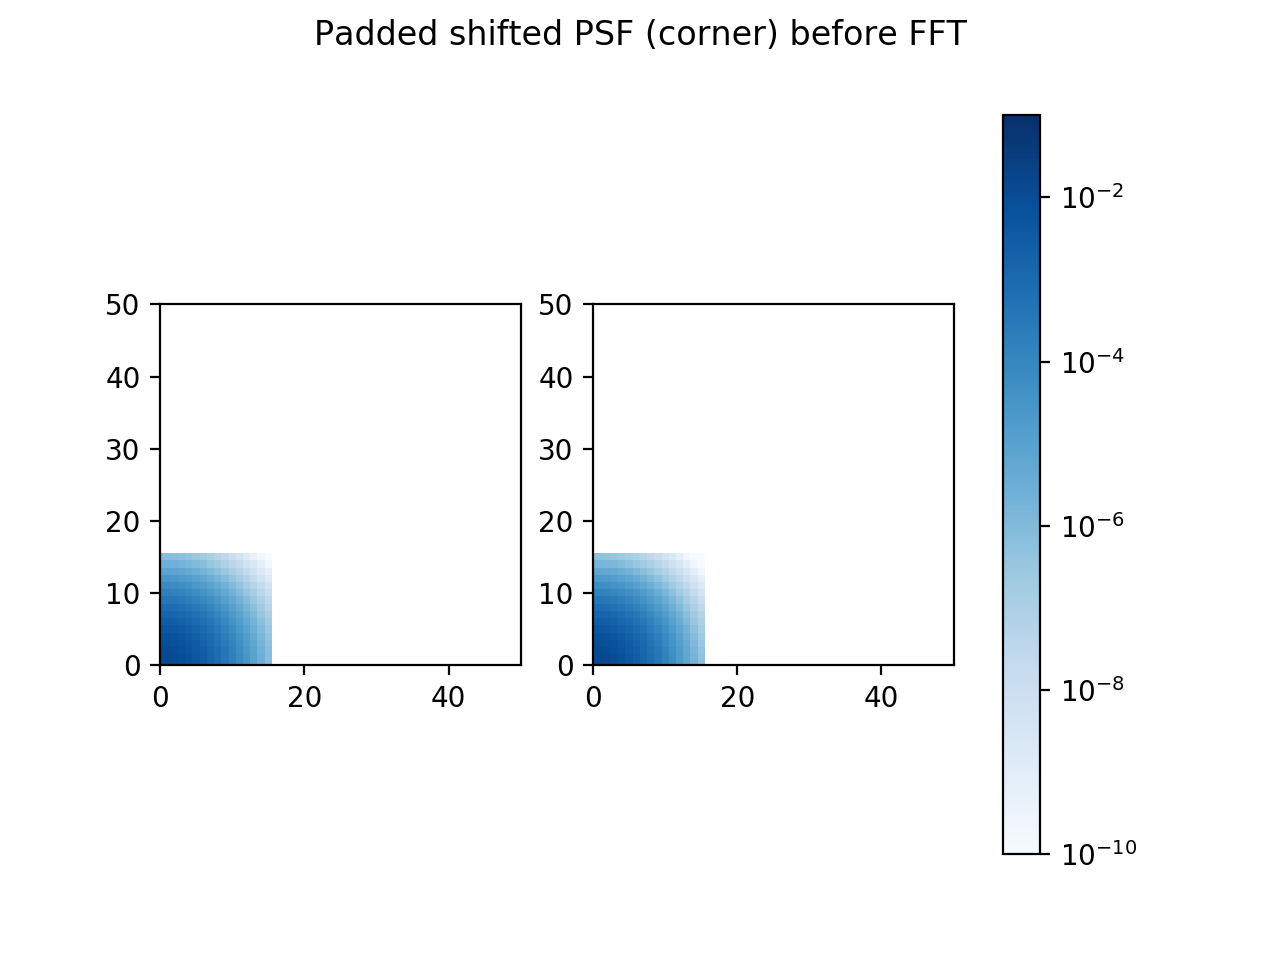

Text(0.5, 0.98, 'Padded shifted PSF (corner) before FFT')

In [5]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
cs = ax1.imshow(pA, origin='bottom', interpolation='none',  cmap='Blues',
               norm=matplotlib.colors.LogNorm(vmin=1e-10,vmax=0.1))
ax2 = fig.add_subplot(1, 2, 2)
cs = ax2.imshow(pB, origin='bottom', interpolation='none',  cmap='Blues',
               norm=matplotlib.colors.LogNorm(vmin=1e-10,vmax=0.1))
fig.colorbar(cs, ax=[ax1, ax2])
ax1.set_xlim(0, 50)
ax1.set_ylim(0, 50)
ax2.set_xlim(0, 50)
ax2.set_ylim(0, 50)
fig.suptitle("Padded shifted PSF (corner) before FFT")

<IPython.core.display.Javascript object>


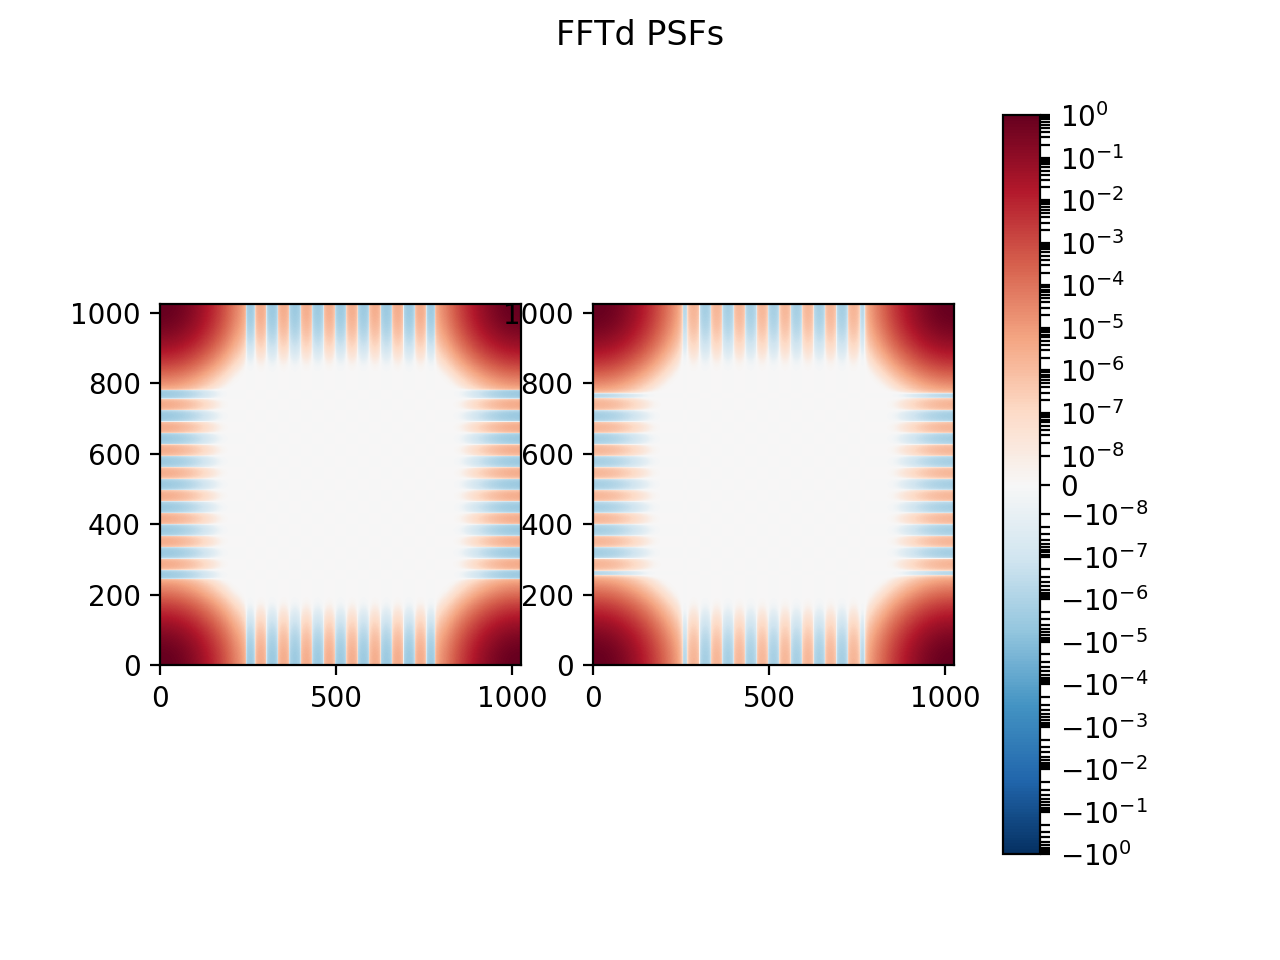

Text(0.5, 0.98, 'FFTd PSFs')

In [6]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
cs = ax1.imshow(psf1.real, origin='bottom', interpolation='none',  cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8,vmin=-1,vmax=1))
ax2 = fig.add_subplot(1, 2, 2)
cs = ax2.imshow(psf2.real, origin='bottom', interpolation='none',  cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8,vmin=-1,vmax=1))
fig.colorbar(cs, ax=[ax1, ax2])
fig.suptitle("FFTd PSFs")

There are some small negative values around in the frequency space PSFs.

In [7]:
# Noise variance in the images
varMean1 = 100
varMean2 = 100
F1 = 1.
F2 = 1. 
var1F2Sq = varMean1*F2*F2
var2F1Sq = varMean2*F1*F1
FdDenom = np.sqrt(var1F2Sq + var2F1Sq)  # one number
# We need reals for comparison, also real operations are usually faster
# Psf absolute squared
psfAbsSq1 = np.real(np.conj(psf1)*psf1)
psfAbsSq2 = np.real(np.conj(psf2)*psf2)
sDenom = var1F2Sq*psfAbsSq2 + var2F1Sq*psfAbsSq1  # array, eq. (12)
# sDenom close to zero check here in the code, here we ignore, we won't hit division by zero
denom = np.sqrt(sDenom)  # array, eq. (13)

sDenom: The squared denominator in the difference image calculation

In [8]:
fPd = FdDenom*psf1*psf2/denom  # Psf of D eq. (14)
fc1 = psf2/denom
fc2 = psf1/denom

In [9]:
print(FdDenom)

14.142135623730951


Check all are real.

In [10]:
print(np.all(fPd.imag == 0), np.all(fc1.imag == 0), np.all(fc2.imag == 0))

True True True


<IPython.core.display.Javascript object>


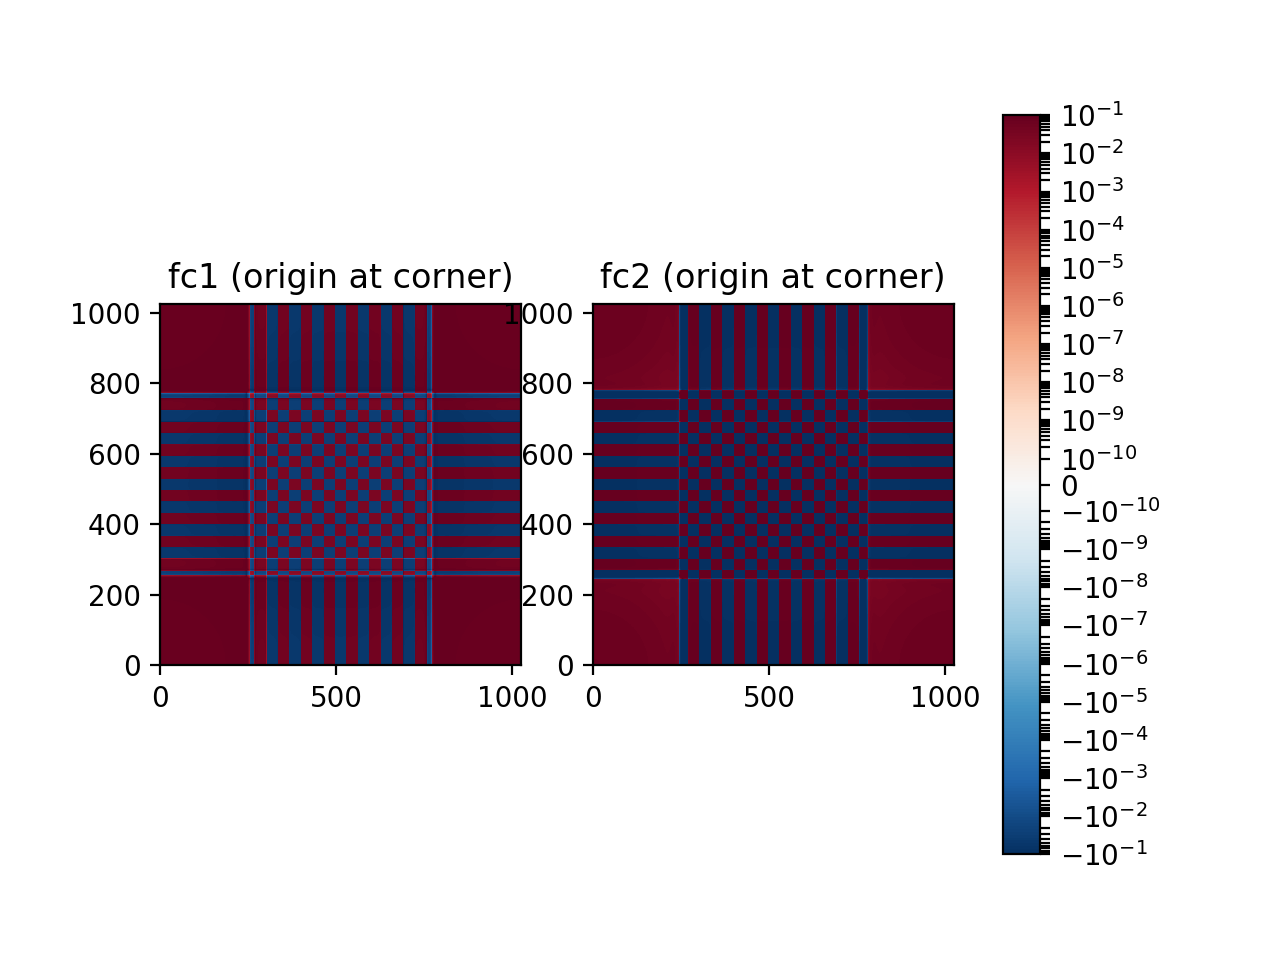

fc1 min -0.09998228574609017
fc1 max 0.09999950054137392
fc2 min -0.09999608963925732
fc2 max 0.09999950054137392


In [11]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
cs = ax1.imshow(fc1.real, origin='bottom', interpolation='none', cmap='RdBu_r',
                norm=matplotlib.colors.SymLogNorm(linthresh=1e-10,vmin=-0.1,vmax=0.1))
ax1.set_title("fc1 (origin at corner)")
ax2 = fig.add_subplot(1, 2, 2)
cs = ax2.imshow(fc2.real, origin='bottom', interpolation='none', cmap='RdBu_r',
                norm=matplotlib.colors.SymLogNorm(linthresh=1e-10,vmin=-0.1,vmax=0.1))
ax2.set_title("fc2 (origin at corner)")
fig.colorbar(cs, ax=[ax1, ax2])
print(f"fc1 min {np.min(fc1.real)}")
print(f"fc1 max {np.max(fc1.real)}")
print(f"fc2 min {np.min(fc2.real)}")
print(f"fc2 max {np.max(fc1.real)}")

The matching kernel for the wider input PSF

<IPython.core.display.Javascript object>


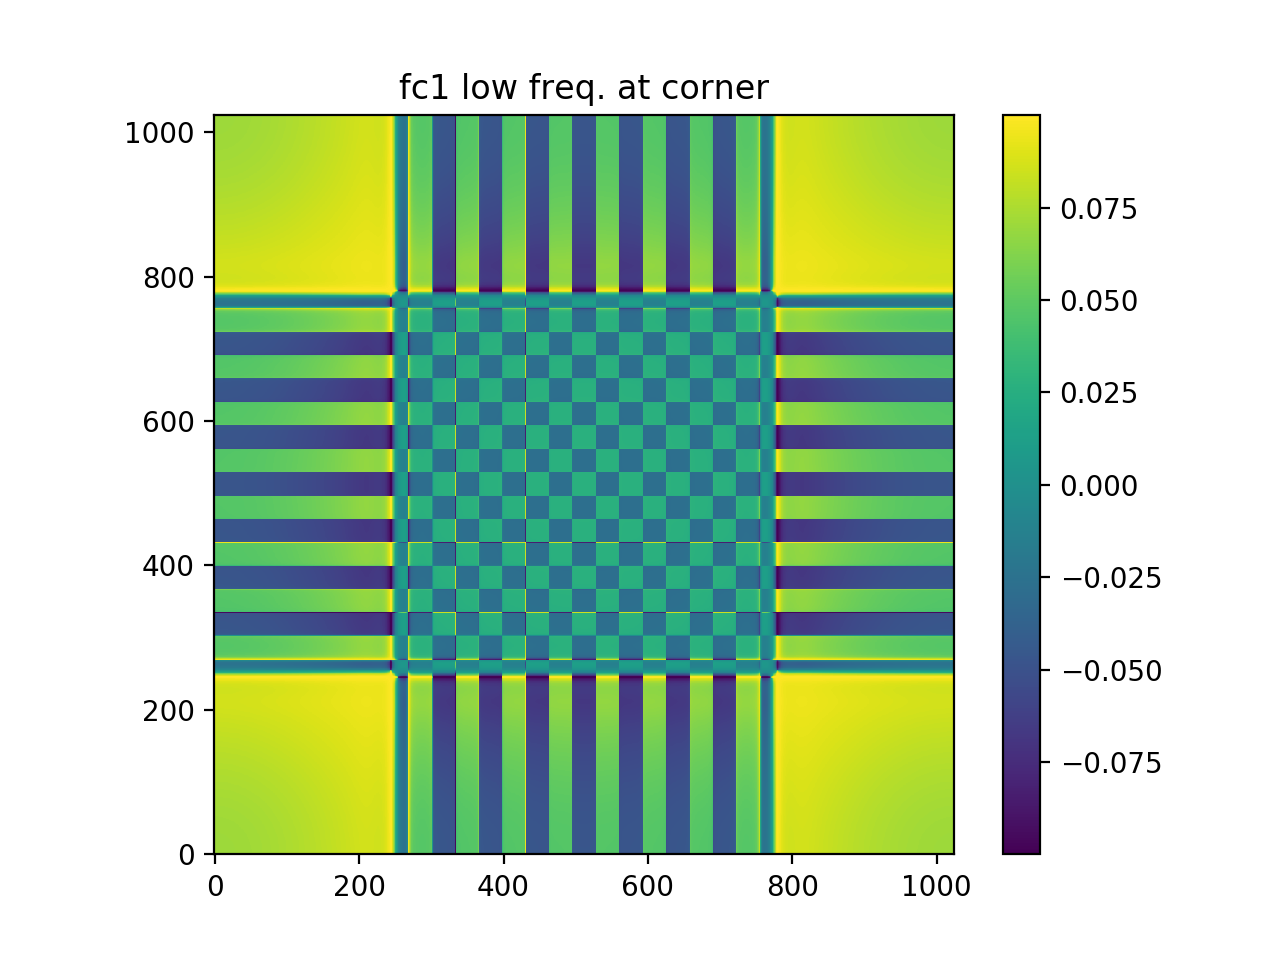

In [12]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
cs = ax1.imshow(fc1.real, origin='bottom', interpolation='none')
ax1.set_title("fc1 low freq. at corner")
fig.colorbar(cs)

<IPython.core.display.Javascript object>


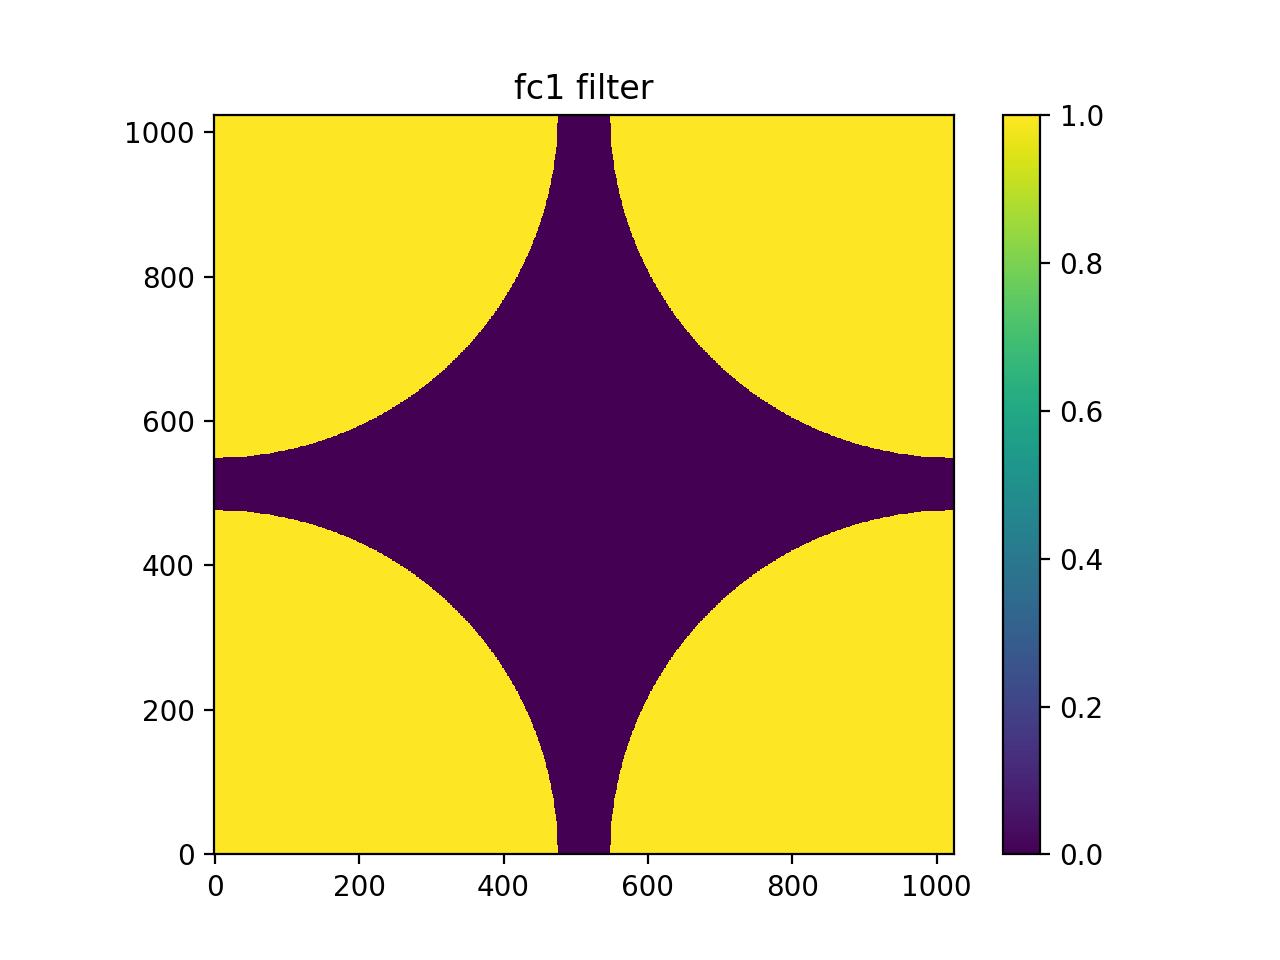

In [13]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
cs = ax1.imshow(np.asarray(freqFlt1, dtype=int), origin='bottom', interpolation='none')
ax1.set_title("fc1 filter")
fig.colorbar(cs)

In [14]:
freqFlt1 = np.logical_not(freqFlt1)
fc1.real[freqFlt1] = 1./np.sqrt(varMean1)

<IPython.core.display.Javascript object>


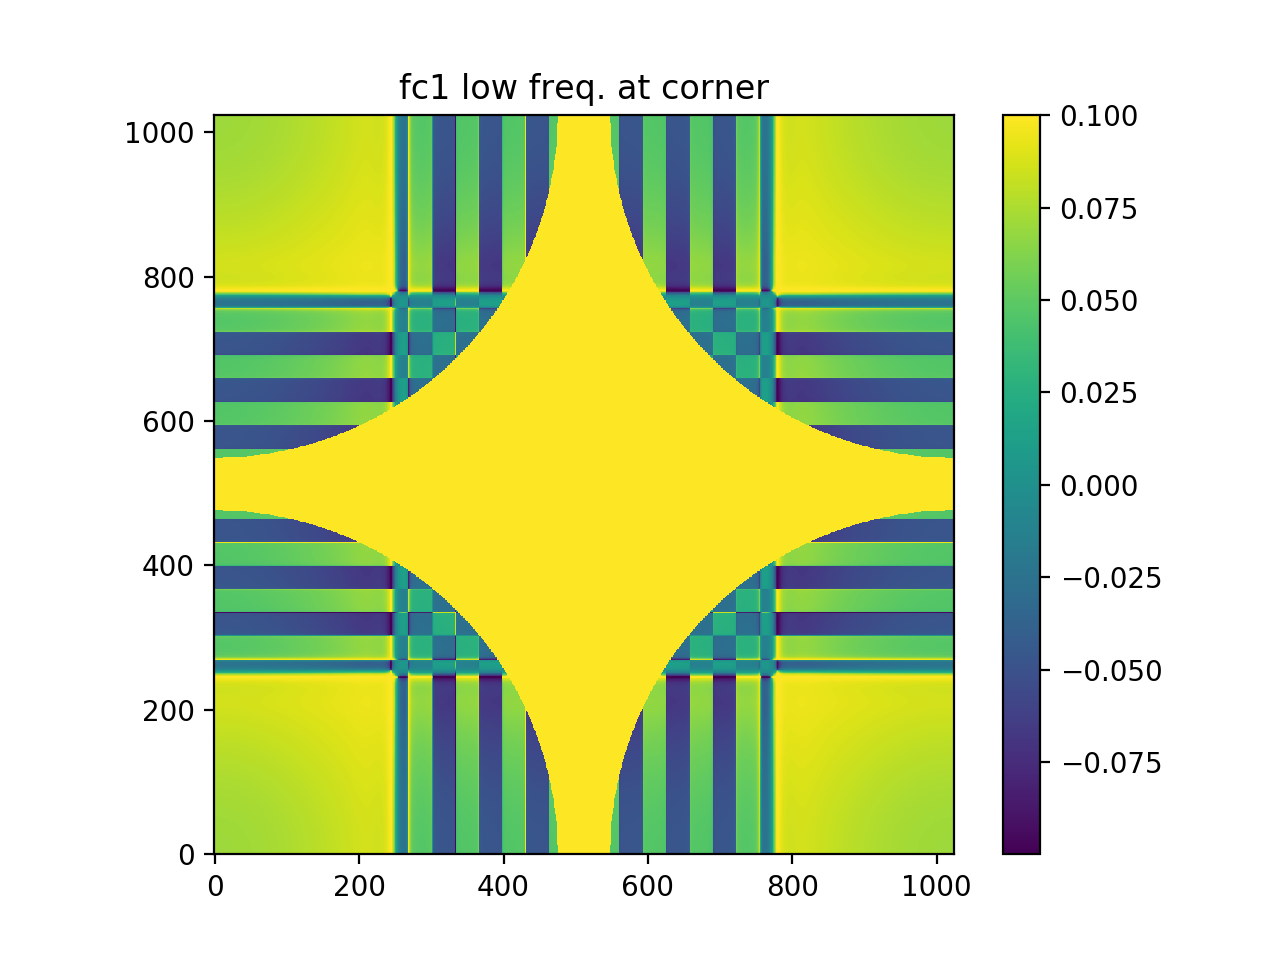

In [15]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
cs = ax1.imshow(fc1.real, origin='bottom', interpolation='none')
ax1.set_title("fc1 low freq. at corner")
fig.colorbar(cs)

The matching kernel for the narrower input PSF

<IPython.core.display.Javascript object>


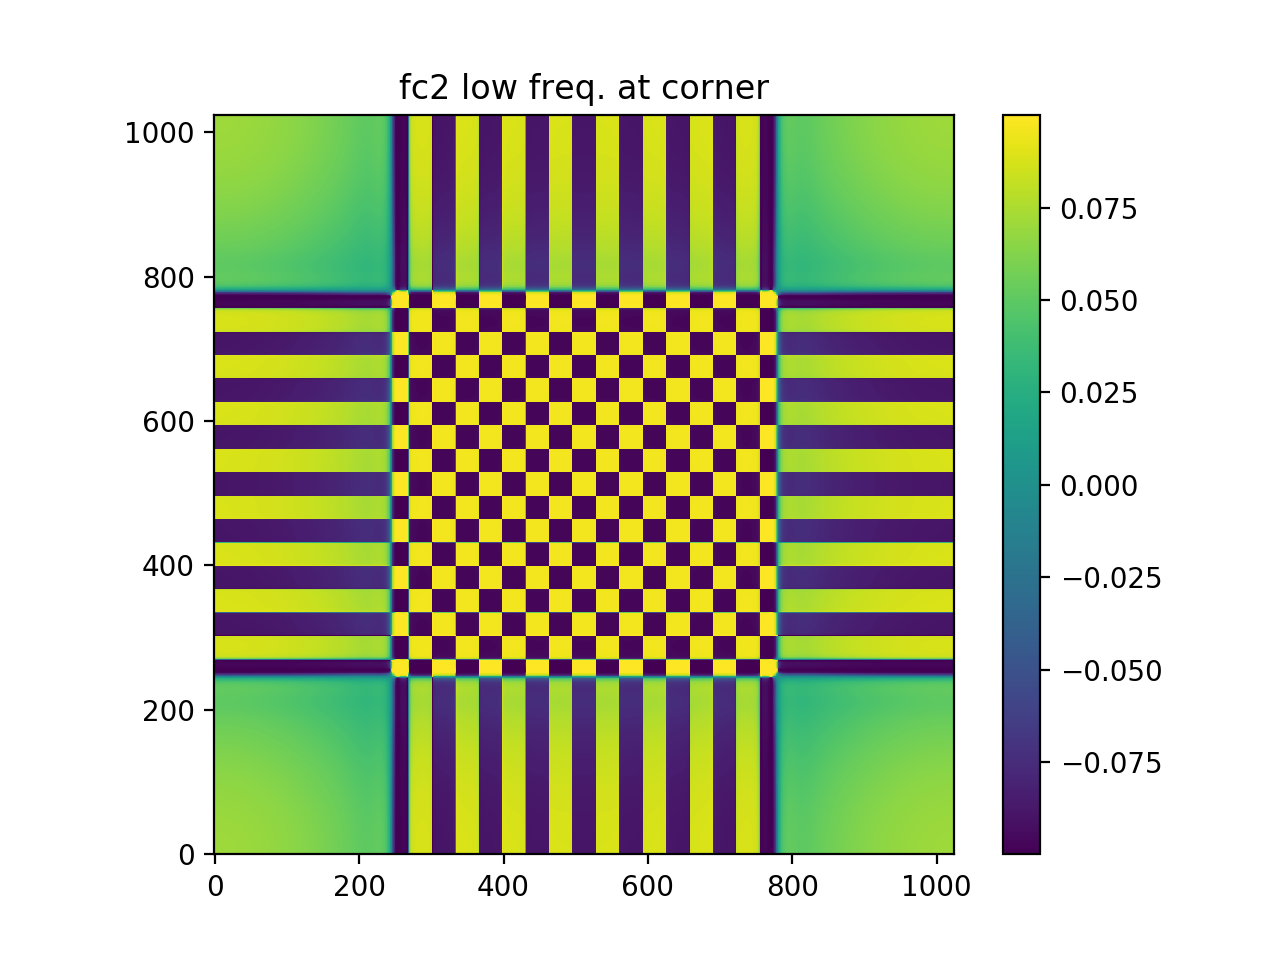

In [16]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
cs = ax1.imshow(fc2.real, origin='bottom', interpolation='none')
ax1.set_title("fc2 low freq. at corner")
fig.colorbar(cs)

<IPython.core.display.Javascript object>


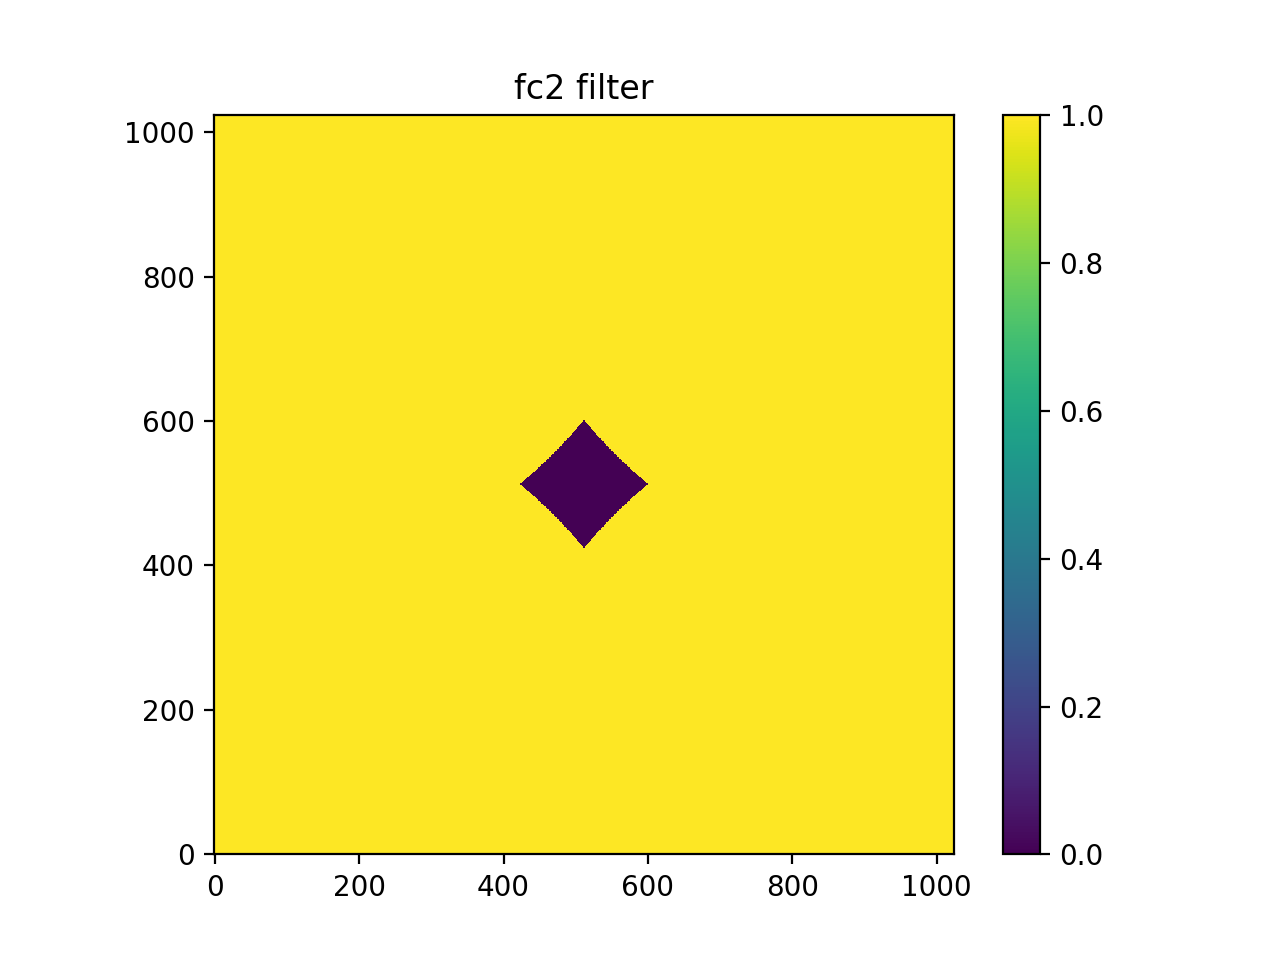

In [17]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
cs = ax1.imshow(np.asarray(freqFlt2, dtype=int), origin='bottom', interpolation='none')
ax1.set_title("fc2 filter")
fig.colorbar(cs)

In [18]:
freqFlt2 = np.logical_not(freqFlt2)
fc2.real[freqFlt2] = 0.

<IPython.core.display.Javascript object>


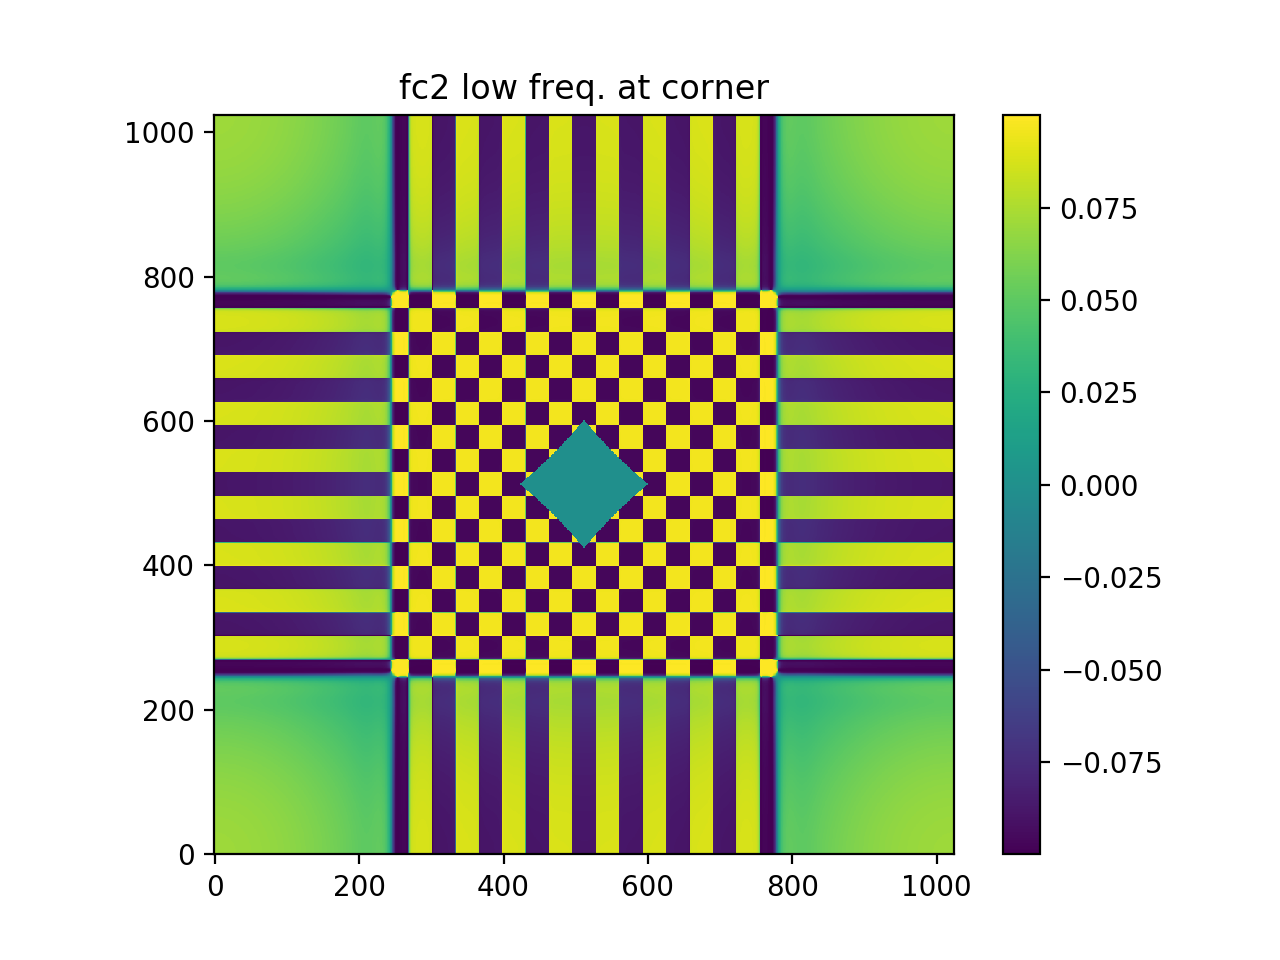

In [19]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
cs = ax1.imshow(fc2.real, origin='bottom', interpolation='none')
ax1.set_title("fc2 low freq. at corner")
fig.colorbar(cs)

In [20]:
Pd = np.real(np.fft.ifft2(fPd))
c1 = np.real(np.fft.ifft2(fc1))
c2 = np.real(np.fft.ifft2(fc2))

The matching kernel for the wider input back in image space

<IPython.core.display.Javascript object>


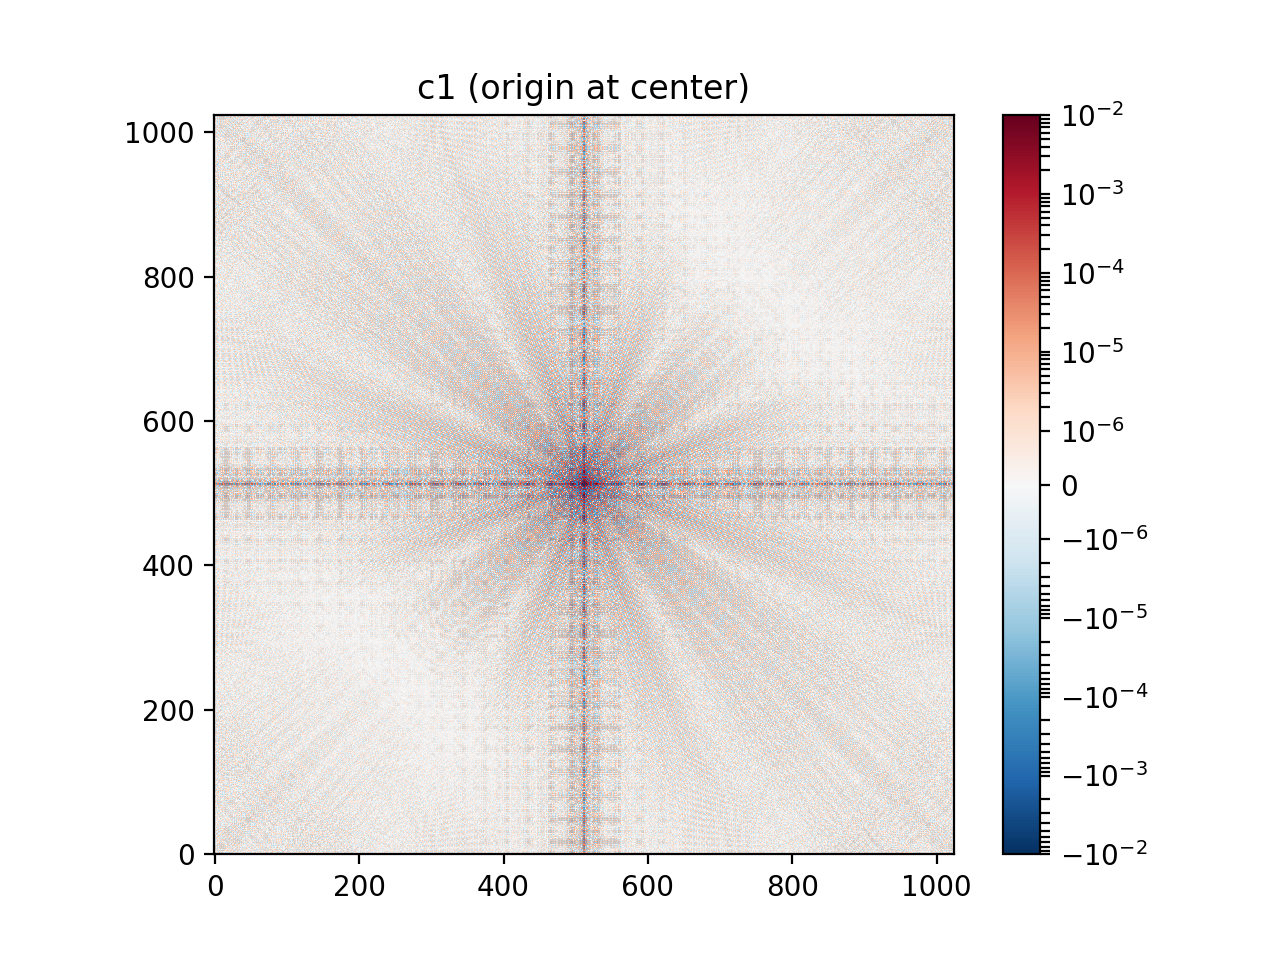

Text(0.5, 1.0, 'c1 (origin at center)')

In [21]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
P2 = task.padCenterOriginArray(c1, (1024,1024), useInverse=True)
cs = ax.imshow(P2, interpolation='none', origin='bottom', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-6,vmin=-0.01,vmax=0.01))
fig.colorbar(cs)
ax.set_title("c1 (origin at center)")

And for the narrower one

<IPython.core.display.Javascript object>


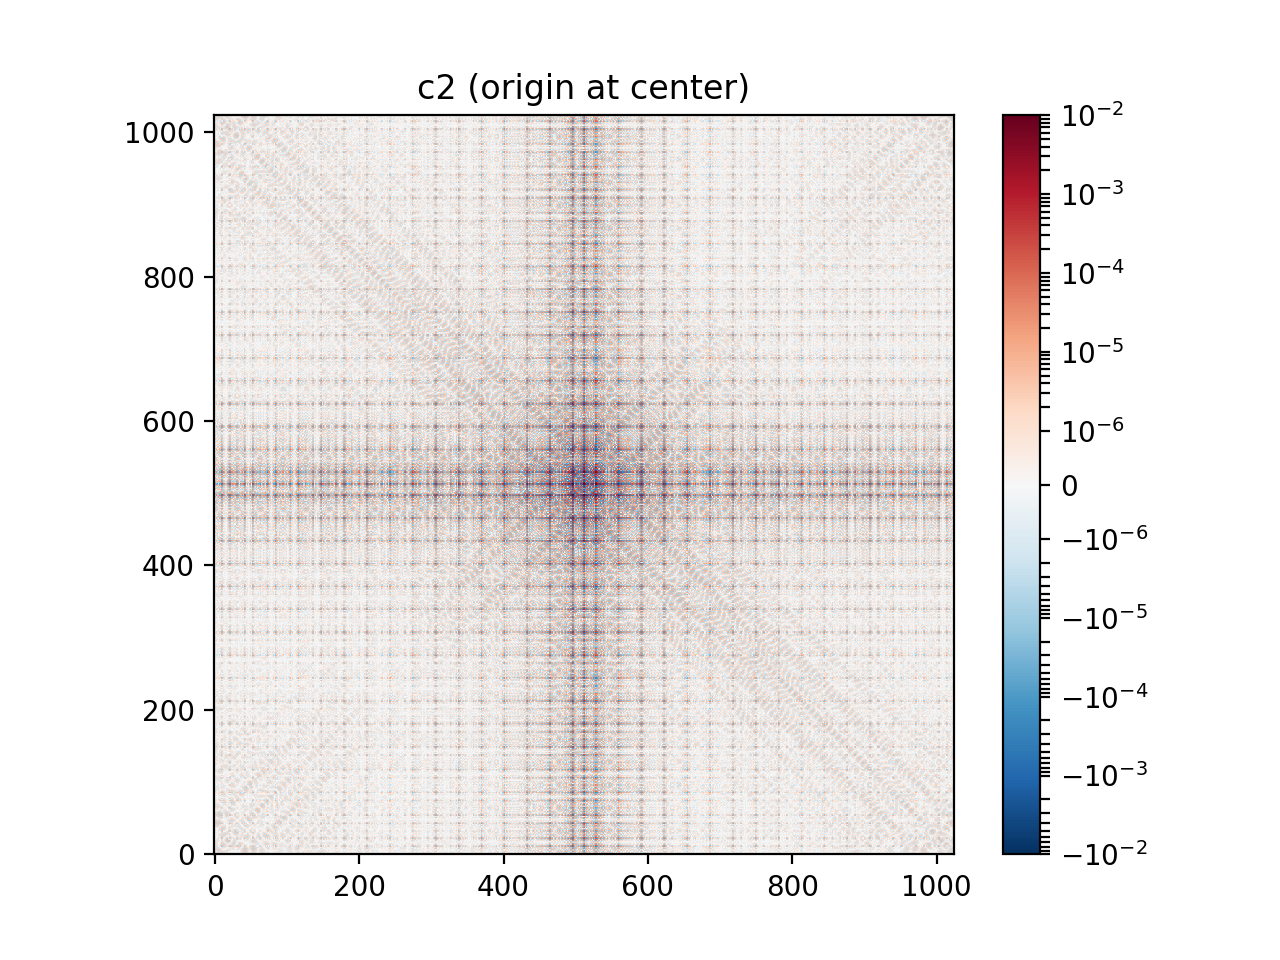

Text(0.5, 1.0, 'c2 (origin at center)')

In [22]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
P2 = task.padCenterOriginArray(c2, (1024,1024), useInverse=True)
cs = ax.imshow(P2, interpolation='none', origin='bottom', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-6,vmin=-0.01,vmax=0.01))
fig.colorbar(cs)
ax.set_title("c2 (origin at center)")

PSF for the difference image

<IPython.core.display.Javascript object>


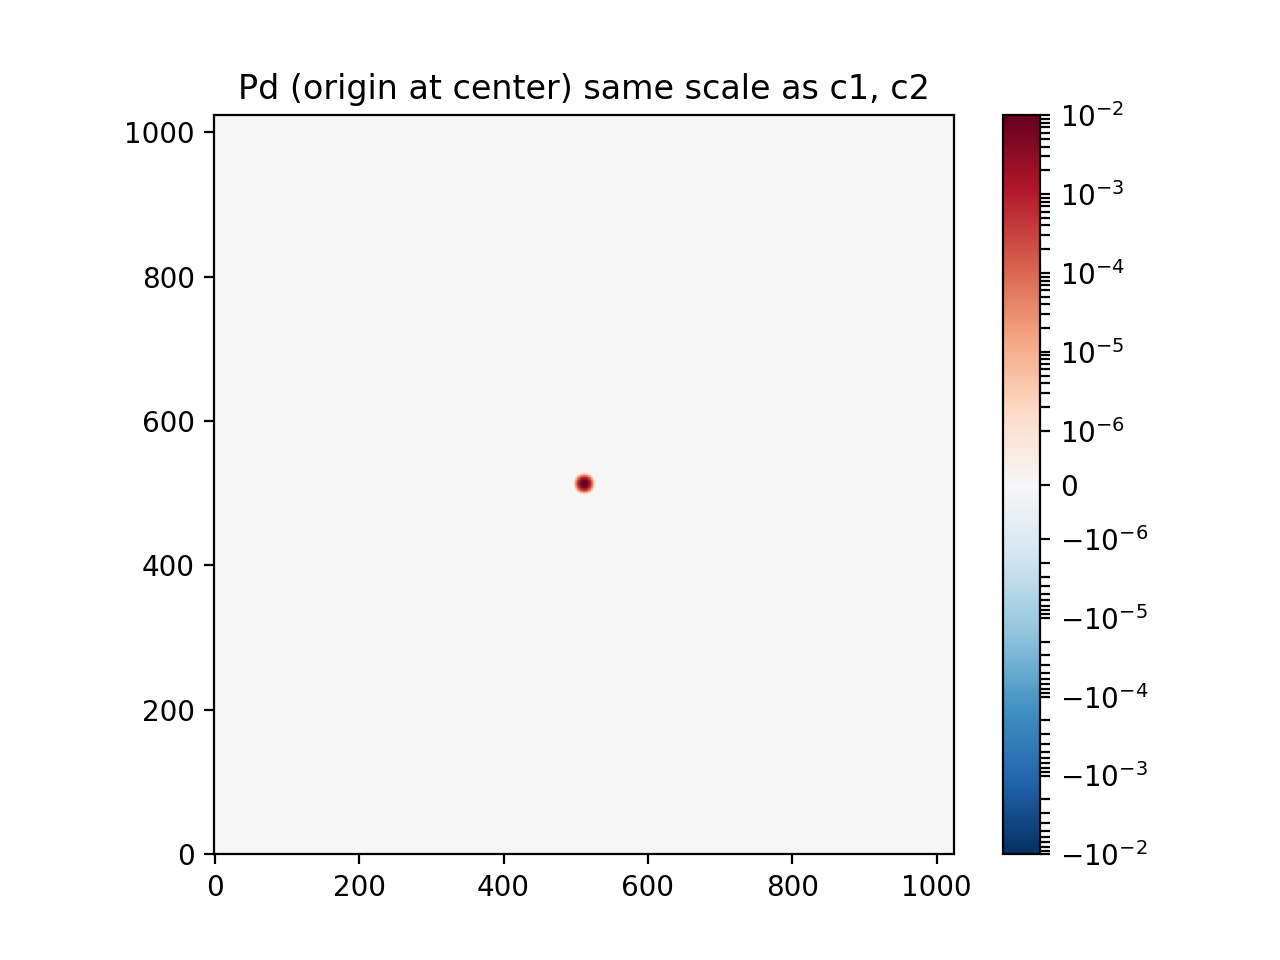

Text(0.5, 1.0, 'Pd (origin at center) same scale as c1, c2')

In [23]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
P2 = task.padCenterOriginArray(Pd, (1024,1024), useInverse=True)
cs = ax.imshow(P2, interpolation='none', origin='bottom', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-6,vmin=-0.01,vmax=0.01))
fig.colorbar(cs)
ax.set_title("Pd (origin at center) same scale as c1, c2")

<IPython.core.display.Javascript object>


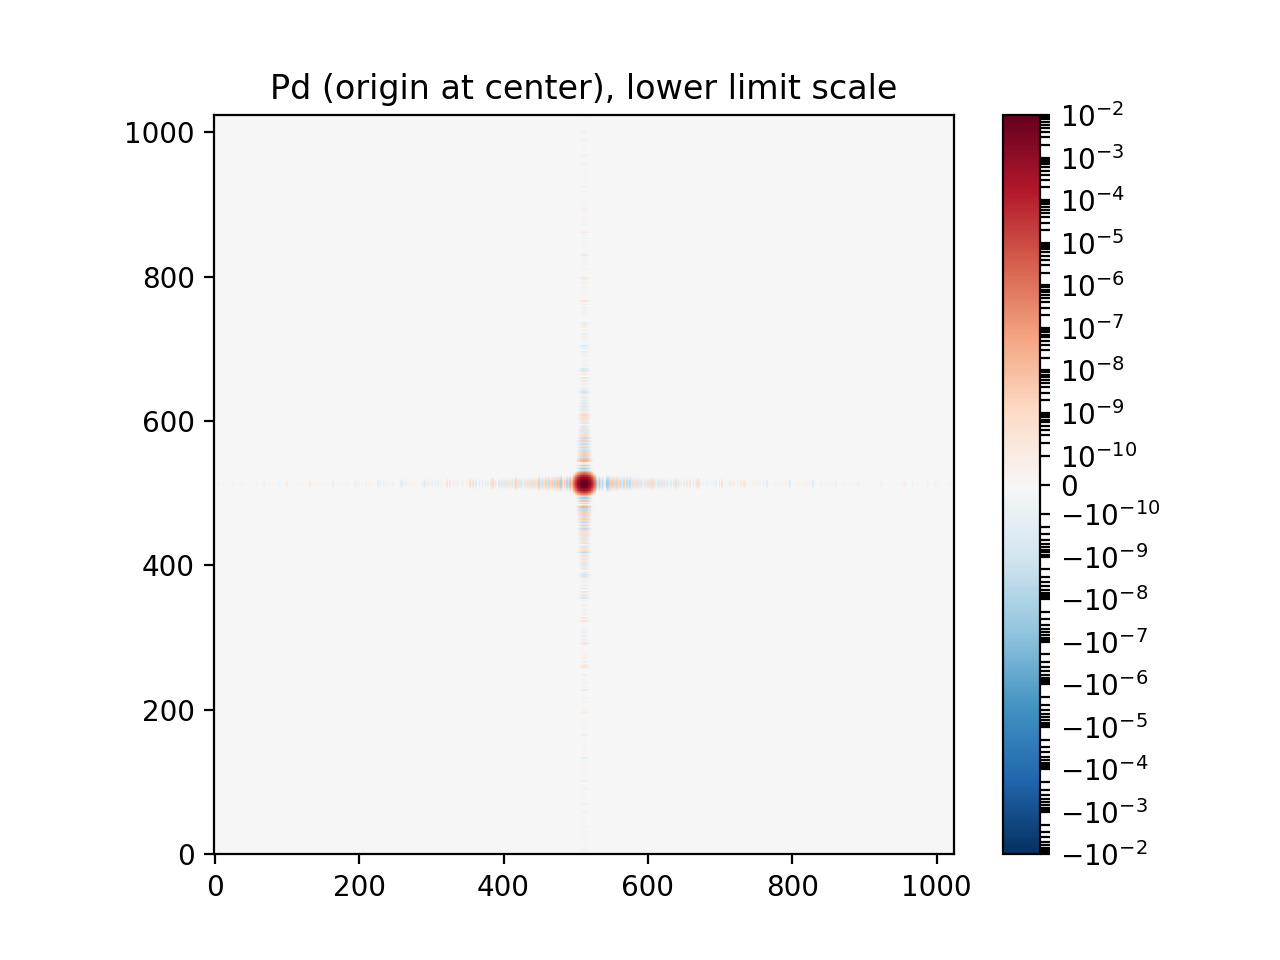

Text(0.5, 1.0, 'Pd (origin at center), lower limit scale')

In [24]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
P2 = task.padCenterOriginArray(Pd, (1024,1024), useInverse=True)
cs = ax.imshow(P2, interpolation='none', origin='bottom', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-10,vmin=-0.01,vmax=0.01))
fig.colorbar(cs)
ax.set_title("Pd (origin at center), lower limit scale")

--------